In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
cpu = 10

lgp_cutoff = 8
log2odds_cutoff = 1

## Load

### Pairwise Motif Enrichment

In [3]:
motif_enrichment_results = pd.read_msgpack('PairwiseMotifEnrichment.msg')
motif_enrichment_results['log2odds'] = np.log2(
    motif_enrichment_results['oddsratio'])
motif_enrichment_results = motif_enrichment_results[
    (motif_enrichment_results['-lgp'] > lgp_cutoff)
    & (motif_enrichment_results['log2odds'].abs() > log2odds_cutoff)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
motif_enrichment_results.shape

(183338, 13)

In [5]:
motif_enrichment_results.head()

,oddsratio,p_value,adj_p,-lgp,left_hit,left_no_hit,right_hit,right_no_hit,left_hit_rate,right_hit_rate,ClusterA,ClusterB,log2odds
MA0027.2,2.199441,1.145486e-202,1.583854e-201,200.800285,3317.0,31516.0,3176.0,66371.0,0.095226,0.045667,Foxp2_Trpc7,MSN-D1_Khdrbs3,1.137137
MA0068.2,2.729698,2.190765e-244,3.750381e-243,242.425925,2668.0,32165.0,2051.0,67496.0,0.076594,0.029491,Foxp2_Trpc7,MSN-D1_Khdrbs3,1.448741
MA0070.1,0.305699,6.838010e-54,4.966191e-53,52.303977,152.0,34681.0,983.0,68564.0,0.004364,0.014134,Foxp2_Trpc7,MSN-D1_Khdrbs3,-1.709814
MA0075.3,3.012484,0.000000e+00,0.000000e+00,300.000000,5223.0,29610.0,3847.0,65700.0,0.149944,0.055315,Foxp2_Trpc7,MSN-D1_Khdrbs3,1.590954
MA0077.1,2.000789,8.669413e-140,8.201721e-139,138.086095,2810.0,32023.0,2922.0,66625.0,0.080671,0.042015,Foxp2_Trpc7,MSN-D1_Khdrbs3,1.000569


In [6]:
def judge_row(row):
    if row['log2odds'] < 0:
        return pd.Series({'enrich': row['ClusterB'], 'null': row['ClusterA']})
    else:
        return pd.Series({'enrich': row['ClusterA'], 'null': row['ClusterB']})


motif_sig_judge = motif_enrichment_results.apply(judge_row, axis=1)

### Dendrogram

In [7]:
node_cluster_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.non_singleton_node_dict.lib'
)

In [8]:
node_possible_count = {}
for node, sub_dict in node_cluster_dict.items():
    possible_pairs = len(sub_dict['left']) * len(sub_dict['right'])
    node_possible_count[node] = possible_pairs
node_possible_count = pd.Series(node_possible_count)

### Gene Meta

In [9]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

## Assign motif to tree

In [10]:
def calculate_node_portion(sub_df):
    nodes_records = {}
    for k, v in node_cluster_dict.items():
        left = [i.replace(' ', '_') for i in v['left']]
        right = [i.replace(' ', '_') for i in v['right']]

        # left enrich, right null
        judge_from_left = sub_df['enrich'].apply(lambda i: i in left)
        judge_to_right = sub_df['null'].apply(lambda i: i in right)

        # right enrich, left hyper
        judge_from_right = sub_df['enrich'].apply(lambda i: i in right)
        judge_to_left = sub_df['null'].apply(lambda i: i in left)

        # this two cancel each other, use the remaining abs as real hits
        # positive means left hypo, negative means right hypo
        total = (judge_from_left & judge_to_right).sum() -\
                (judge_from_right & judge_to_left).sum()
        nodes_records[k] = total
    nodes_records = pd.Series(nodes_records) / node_possible_count
    return nodes_records

In [11]:
total_result = {}
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for motif, sub_df in motif_sig_judge.groupby(motif_sig_judge.index):
        future = executor.submit(calculate_node_portion, sub_df)
        futures[future] = motif
        
    for future in as_completed(futures):
        result = future.result()
        gene = futures[future]
        total_result[gene] = result
total_result = pd.DataFrame(total_result)

In [12]:
mask_cutoff = 0.1

masked_result = total_result.copy()
masked_result[masked_result.abs() < mask_cutoff] = 0

In [13]:
# gene that assign to at least one node
((masked_result != 0).sum(axis=0) != 0).sum()

508

In [14]:
# node that has at least 5 genes
((masked_result != 0).sum(axis=1) > 5).sum()

76

In [15]:
masked_result.apply(lambda i: 0 if i.abs().max() == 0 else i.abs().idxmax(), axis=0)

MA0003.4    103
MA0014.3    137
MA0017.2    140
MA0019.1     79
MA0018.4     92
           ... 
MA1650.1    110
MA1653.1    117
MA1656.1    122
MA1683.1     84
MA1655.1    103
Length: 560, dtype: int64

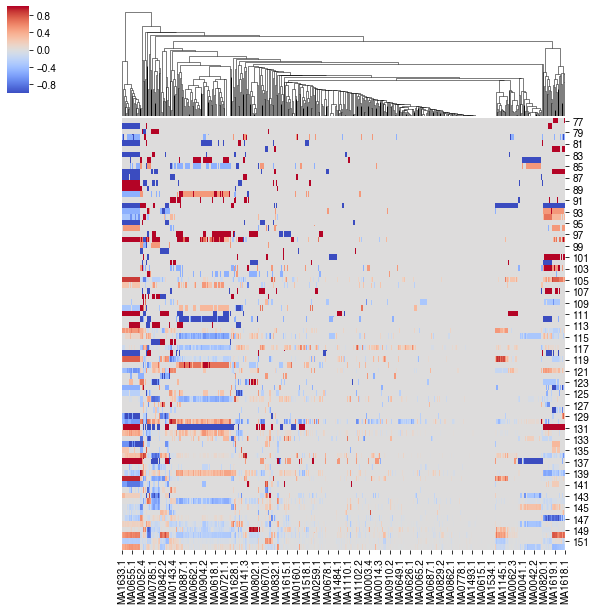

In [16]:
sns.clustermap(total_result, row_cluster=False, cmap='coolwarm')

In [17]:
total_result.to_msgpack('NodeMotifResults.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.
